# Alumno: Gerardo de Miguel González

# Machine Learning II (Master en Data Science, UIMP-UC) 

# Tarea: Redes Bayesianas

### Fecha de entrega: 7 Abril 2019

Responde a las preguntas planteadas y aporta el código en R utilizado para responderlas. Se debe enviar un único documento con texto y código entrelazado, bien sea en formato pdf o html.

## Introducción a la práctica

Utilizaremos un conjunto de datos diarios de ocurrencia de meteoros en el aeropuerto de Parayas (Santander), considerando una serie de variables meteorológicas registradas diariamente durante un periodo aproximado de 10 años (3286 registros), en concreto: precipitación, nieve, granizo, tormenta, niebla, rocío, escarcha, nieve en el suelo, neblina y racha máxima de viento superior a 50 km/h. Los datos se encuentran guardados en el fichero de texto `meteoro.txt`. Las variables se encuentran discretizadas de forma binaria (ocurrencia/ausencia).

En este caso, y a través del asesoramiento de un meteorólogo, se ha elaborado el siguiente diagrama acíclico dirigido (DAG), que recoge las relaciones de dependencia entre las variables:

![modelo experto](dag-meteo-modelo-experto.png)

In [1]:
suppressMessages(library('bnlearn'))

## Ejercicio 1 (2.5 Puntos)

* A partir del grafo dado por el experto, determina la expresión que refleja la factorización de la distribución global, y escríbela como una secuencia de caracteres del tipo generado por la función `modelstring` del paquete de R `bnlearn`. 

In [2]:
# https://stackoverflow.com/questions/6329962/split-code-over-multiple-lines-in-an-r-script
meteoro_dag <- paste('[viento][lluvia|viento][rocio|viento][tormenta|lluvia][niebla|rocio:viento]',
                      '[escarcha|rocio][nieve|tormenta][granizo|tormenta][neblina|niebla][nieveSuelo|nieve]',
                      sep="")
print(meteoro_dag)

[1] "[viento][lluvia|viento][rocio|viento][tormenta|lluvia][niebla|rocio:viento][escarcha|rocio][nieve|tormenta][granizo|tormenta][neblina|niebla][nieveSuelo|nieve]"


NOTA: Como ya se comentado anteriormente, es importante evitar tildes a la hora de nombrar los nodos. Tampoco son recomendables espacios en blanco ni ningún tipo de carácter especial. 

* A continuación, introduce el DAG en R utilizando la definicíon del modelo que acabas de crear

In [3]:
# http://www.bnlearn.com/documentation/man/modelstring.html
dag <- bnlearn::model2network(string = meteoro_dag)

In [4]:
#::GMG::Alternativa según la documentación oficial de bnlearn
dag2 <- bnlearn::as.bn(meteoro_dag)

In [5]:
#::GMG::Compruebo que ambas formas son equivalentes
all.equal(target = dag, current = dag2)

[1] TRUE

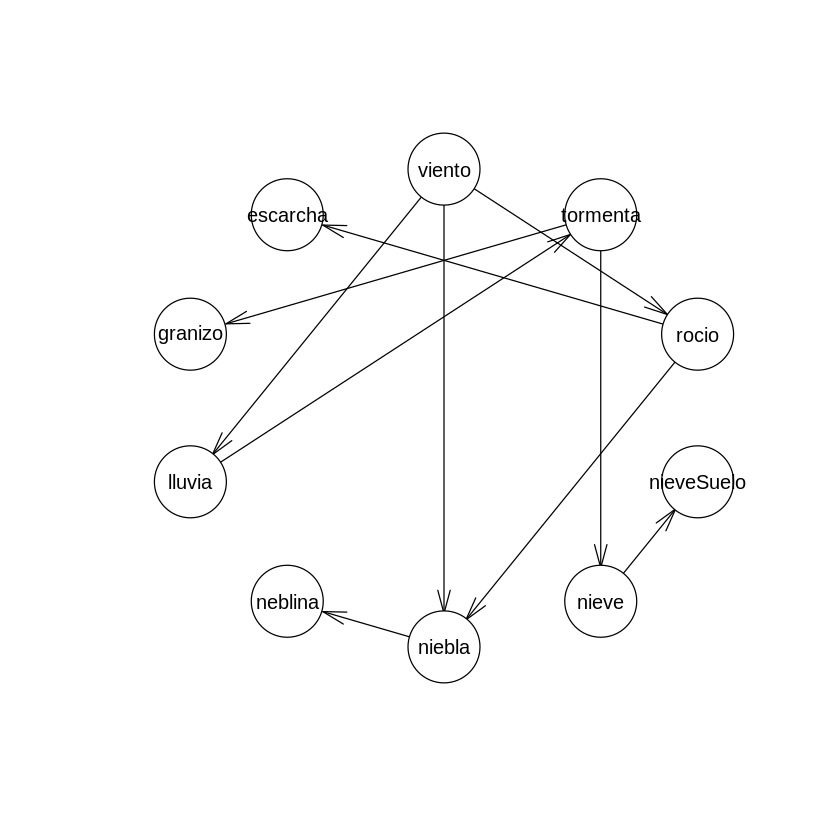

In [6]:
plot(dag)

* Obten una lista de los padres e hijos de cada uno de los nodos

In [7]:
print(bnlearn::nodes(object = dag))

 [1] "escarcha"   "granizo"    "lluvia"     "neblina"    "niebla"    
 [6] "nieve"      "nieveSuelo" "rocio"      "tormenta"   "viento"    


In [8]:
# http://bnlearn.com/documentation/man/mb.html
for (n in bnlearn::nodes(dag)) {
  cat("Node: ", n,
      "-> Parent: ",
      bnlearn::parents(x = dag, node = n),
      '\n'
     ) 
}

Node:  escarcha -> Parent:  rocio 
Node:  granizo -> Parent:  tormenta 
Node:  lluvia -> Parent:  viento 
Node:  neblina -> Parent:  niebla 
Node:  niebla -> Parent:  rocio viento 
Node:  nieve -> Parent:  tormenta 
Node:  nieveSuelo -> Parent:  nieve 
Node:  rocio -> Parent:  viento 
Node:  tormenta -> Parent:  lluvia 
Node:  viento -> Parent:   


In [9]:
for (n in bnlearn::nodes(dag)) {
    cat("Node: ", n,
      "-> Children: ",
      children(x = dag, node = n),
      '\n'
     ) 
}

Node:  escarcha -> Children:   
Node:  granizo -> Children:   
Node:  lluvia -> Children:  tormenta 
Node:  neblina -> Children:   
Node:  niebla -> Children:  neblina 
Node:  nieve -> Children:  nieveSuelo 
Node:  nieveSuelo -> Children:   
Node:  rocio -> Children:  escarcha niebla 
Node:  tormenta -> Children:  granizo nieve 
Node:  viento -> Children:  lluvia niebla rocio 


* Realiza una lista de todas las conexiones fundamentales presentes en el grafo, y realiza una clasificación de cada una de ellas determinando si es una estructura en serie, divergente o convergente.

In [10]:
bnlearn::arcs(x = dag)

from,to
viento,lluvia
viento,rocio
lluvia,tormenta
rocio,niebla
viento,niebla
rocio,escarcha
tormenta,nieve
tormenta,granizo
niebla,neblina
nieve,nieveSuelo


**::GMG::** Lo hago de forma visual con el grafo del enunciado por que no encuentro la manera de hacerlo en código usando [funciones de bnlearn](http://bnlearn.com/documentation/man/mb.html)  

**serie**

(1) {viento, lluvia, tormenta}

**divergente**

(1) {tormenta, granizo, nieve}

(2) {rocio, niebla, escarcha}

**convergente**

(1) {viento, niebla, rocio}

* ¿Se observa alguna *v-estructura* en el grafo?

In [11]:
# http://www.bnlearn.com/documentation/man/cpdag.html
# as in Koller and Friedman (2009)
bnlearn::vstructs(x = dag, moral = TRUE, debug = TRUE)

* scanning the graph (step 1).
  > node niebla is the center of a v-structure.
* marking v-structures (step 2).
  > fixing arc rocio -> niebla, it's part of a v-structure.
  > fixing arc viento -> niebla, it's part of a v-structure.


X,Z,Y
rocio,niebla,viento


In [12]:
# as in Pearl (2000)
bnlearn::vstructs(x = dag, moral = FALSE, debug = TRUE)

* scanning the graph (step 1).
  > node niebla is the center of a v-structure.
* marking v-structures (step 2).
  > fixing arc rocio -> niebla, it's part of a v-structure.
  > fixing arc viento -> niebla, it's part of a v-structure.
* removing moral v-structures aka shielded colliders.
  > considering arc rocio -> niebla.
    > considering v-structure rocio -> niebla <- viento.
  @ arc rocio -> niebla is not part of a v-structure.
  > considering arc viento -> niebla.
  @ arc viento -> niebla is not part of a v-structure.


X,Z,Y


* Intenta introducir un arco que parta del nodo neblina y se dirija hacia escarcha, y otro que vaya de granizo a lluvia. Comenta qué sucede en cada caso, y si el resultado daría lugar a una red bayesiana válida.

In [13]:
# http://www.bnlearn.com/documentation/man/arcops.html
#::nota::hago el cambio en pdag2 y consrvo el "original" en pdag
dag2 <- bnlearn::set.arc(x = dag2, from = 'neblina', to = 'escarcha', 
                         debug = TRUE)

* setting arc neblina -> escarcha .
  > the arc neblina -> escarcha is not present, adding.
* building the adjacency matrix.
* checking whether the partially directed graph is acyclic.
* beginning iteration 1.
  > checking node escarcha (0 child(ren), 2 parent(s), 0 neighbours).
  @ node escarcha is cannot be part of a cycle.
  > checking node granizo (0 child(ren), 1 parent(s), 0 neighbours).
  @ node granizo is cannot be part of a cycle.
  > checking node lluvia (1 child(ren), 1 parent(s), 0 neighbours).
  > checking node neblina (0 child(ren), 1 parent(s), 0 neighbours).
  @ node neblina is cannot be part of a cycle.
  > checking node niebla (0 child(ren), 2 parent(s), 0 neighbours).
  @ node niebla is cannot be part of a cycle.
  > checking node nieve (1 child(ren), 1 parent(s), 0 neighbours).
  > checking node nieveSuelo (0 child(ren), 1 parent(s), 0 neighbours).
  @ node nieveSuelo is cannot be part of a cycle.
  > checking node rocio (0 child(ren), 1 parent(s), 0 neighbours).
  

In [14]:
#::GMG::arco agregado
bnlearn::arcs(x = dag2)

from,to
viento,lluvia
viento,rocio
lluvia,tormenta
rocio,niebla
viento,niebla
rocio,escarcha
tormenta,nieve
tormenta,granizo
niebla,neblina
nieve,nieveSuelo


In [15]:
#bnlearn::drop.arc(x = pdag2, from = 'neblina', to = 'escarcha')

In [16]:
#::GMG::arco NO agregado por introducción de ciclo
dag2 <- bnlearn::set.arc(x = dag2, from = 'granizo', to = 'lluvia', 
                         debug = TRUE)

* setting arc granizo -> lluvia .
  > the arc granizo -> lluvia is not present, adding.
* building the adjacency matrix.
* checking whether the partially directed graph is acyclic.
* beginning iteration 1.
  > checking node escarcha (0 child(ren), 2 parent(s), 0 neighbours).
  @ node escarcha is cannot be part of a cycle.
  > checking node granizo (1 child(ren), 1 parent(s), 0 neighbours).
  > checking node lluvia (1 child(ren), 2 parent(s), 0 neighbours).
  > checking node neblina (0 child(ren), 1 parent(s), 0 neighbours).
  @ node neblina is cannot be part of a cycle.
  > checking node niebla (0 child(ren), 2 parent(s), 0 neighbours).
  @ node niebla is cannot be part of a cycle.
  > checking node nieve (1 child(ren), 1 parent(s), 0 neighbours).
  > checking node nieveSuelo (0 child(ren), 1 parent(s), 0 neighbours).
  @ node nieveSuelo is cannot be part of a cycle.
  > checking node rocio (0 child(ren), 1 parent(s), 0 neighbours).
  @ node rocio is cannot be part of a cycle.
  > chec

ERROR: Error in arc.operations(x = x, from = from, to = to, op = "set", check.cycles = check.cycles, : the resulting graph contains cycles.


In [17]:
#::GMG::arco NO agregado
bnlearn::arcs(x = dag2)

from,to
viento,lluvia
viento,rocio
lluvia,tormenta
rocio,niebla
viento,niebla
rocio,escarcha
tormenta,nieve
tormenta,granizo
niebla,neblina
nieve,nieveSuelo


**::GMG::** El primer arco produce un *loop* pero no un *cycle*. En un DAG eso es correcto. En cambio el segundo *produce un cycle* con lo que se viola la condición de *acyclic* del DAG. Se produce un error (y *no se añade* el arco eal grafo) porque en `set.arc` se tiene por defecto la comprobación de la introducción de *cycles*, i.e `check.cycles = TRUE`  según la [documentación](http://www.bnlearn.com/documentation/man/arcops.html).

```ipython
@ no change in the last iteration.

Error in arc.operations(x = x, from = from, to = to, op = "set", check.cycles = check.cycles, : the resulting graph contains cycles.
Traceback:

1. bnlearn::set.arc(x = pdag2, from = "granizo", to = "lluvia", 
 .     debug = TRUE)
2. arc.operations(x = x, from = from, to = to, op = "set", check.cycles = check.cycles, 
 .     check.illegal = check.illegal, debug = debug)
3. stop("the resulting graph contains cycles.")
```

* Determina la manta de Markov del nodo `rocio`

In [18]:
#::GMG::Los padres de rocio
c1 <- bnlearn::parents(x = dag2, node = 'rocio')
c1

[1] "viento"

In [19]:
#::GMG::Los hijos de rocio
c2 <- bnlearn::children(x = dag2, node = 'rocio')
c2

[1] "escarcha" "niebla"

In [20]:
#::GMG::Los padres de los hijos de rocio
c3 <- c()
for (n in bnlearn::children(x = dag2, node = 'rocio')) {
    c3 <- union(x = c3, y = bnlearn::parents(x = dag2, node = n))
}
c3

[1] "neblina" "rocio"   "viento"

In [21]:
#::GMG::rocio no cuenta
mb_rocio <- setdiff(x = union(x = c1,
                              y = union(x = c2, y = c3)),
                    y = 'rocio')
mb_rocio

[1] "viento"   "escarcha" "niebla"   "neblina"

In [22]:
# http://www.bnlearn.com/documentation/man/mb.html
bnlearn::mb(x = dag2, node = 'rocio')

[1] "escarcha" "neblina"  "niebla"   "viento"

* Introduce un arco que parta del nodo Lluvia y se dirija al nodo Niebla, ¿cambia la manta de Markov del nodo `rocio`? En caso afirmativo, ¿cómo lo hace?

In [23]:
dag2 <- bnlearn::set.arc(x = dag2, from = 'lluvia', to = 'niebla')

In [24]:
bnlearn::arcs(x = dag2)

from,to
viento,lluvia
viento,rocio
lluvia,tormenta
rocio,niebla
viento,niebla
rocio,escarcha
tormenta,nieve
tormenta,granizo
niebla,neblina
nieve,nieveSuelo


**::GMG::** El arco introducido crea un *nuevo padre* (`lluvia`)  en uno de los hijos de rocio (`niebla`) por lo que *se incluirá* en su Markov Blanket (por definición).  

In [25]:
bnlearn::mb(x = dag2, node = 'rocio')

[1] "escarcha" "lluvia"   "neblina"  "niebla"   "viento"

NOTA: Para continuar, elimina el arco definido anteriormente entre los nodos Lluvia y Niebla, recuperando el DAG original.

**::GMG::** Entiendo que se recupera el dag original sin los *dos arcos* que se han introducido. Yo tengo el dag original en `pdag`. No necesito `drop.arc` para recuperar el *grafo original*.

## Ejercicio 2 (2.5 Puntos)

* Considerando la información proporcionada por el conjunto de datos `meteor`, construye la red bayesiana utilizando el método bayesiano de estimación paramétrica.

In [16]:
meteoro <- read.table('meteoro.txt', header = TRUE)

In [17]:
str(meteoro)

'data.frame':	3286 obs. of  10 variables:
 $ lluvia    : Factor w/ 2 levels "n","s": 2 2 2 2 2 2 2 2 2 1 ...
 $ nieve     : Factor w/ 2 levels "n","s": 1 1 1 1 1 1 1 1 1 1 ...
 $ granizo   : Factor w/ 2 levels "n","s": 1 1 1 1 2 2 1 1 1 1 ...
 $ tormenta  : Factor w/ 2 levels "n","s": 1 1 2 1 2 2 2 1 1 1 ...
 $ niebla    : Factor w/ 2 levels "n","s": 1 1 1 1 1 1 1 1 1 1 ...
 $ rocio     : Factor w/ 2 levels "n","s": 1 1 1 1 1 1 1 1 1 2 ...
 $ escarcha  : Factor w/ 2 levels "n","s": 1 1 1 1 1 1 1 1 1 1 ...
 $ nieveSuelo: Factor w/ 2 levels "n","s": 1 1 1 1 1 1 1 1 1 1 ...
 $ neblina   : Factor w/ 2 levels "n","s": 1 1 1 1 1 1 1 1 2 2 ...
 $ viento    : Factor w/ 2 levels "n","s": 2 2 2 2 2 2 2 2 1 1 ...


In [18]:
head(meteoro)

lluvia,nieve,granizo,tormenta,niebla,rocio,escarcha,nieveSuelo,neblina,viento
s,n,n,n,n,n,n,n,n,s
s,n,n,n,n,n,n,n,n,s
s,n,n,s,n,n,n,n,n,s
s,n,n,n,n,n,n,n,n,s
s,n,s,s,n,n,n,n,n,s
s,n,s,s,n,n,n,n,n,s


In [19]:
nodos <- colnames(meteoro)
print(nodos)

 [1] "lluvia"     "nieve"      "granizo"    "tormenta"   "niebla"    
 [6] "rocio"      "escarcha"   "nieveSuelo" "neblina"    "viento"    


In [20]:
nodes(dag)

[1] "escarcha"   "granizo"    "lluvia"     "neblina"    "niebla"    
 [6] "nieve"      "nieveSuelo" "rocio"      "tormenta"   "viento"

In [21]:
arcs(dag)

from,to
viento,lluvia
viento,rocio
lluvia,tormenta
rocio,niebla
viento,niebla
rocio,escarcha
tormenta,nieve
tormenta,granizo
niebla,neblina
nieve,nieveSuelo


In [22]:
modelstring(dag)

[1] "[viento][lluvia|viento][rocio|viento][escarcha|rocio][niebla|rocio:viento][tormenta|lluvia][granizo|tormenta][neblina|niebla][nieve|tormenta][nieveSuelo|nieve]"

In [23]:
class(dag)

[1] "bn"

In [24]:
#::GMG::Aprendo los parámetros (CPT distribuciones locales)
# http://www.bnlearn.com/documentation/man/bn.fit.html
bn_meteoro = bn.fit(x = dag, 
                    data = meteoro, 
                    method = "bayes", 
                    debug = TRUE)

* fitting parameters of node escarcha (discrete).
  > found parents: rocio 
  > fitted 4 conditional probabilities.
* fitting parameters of node granizo (discrete).
  > found parents: tormenta 
  > fitted 4 conditional probabilities.
* fitting parameters of node lluvia (discrete).
  > found parents: viento 
  > fitted 4 conditional probabilities.
* fitting parameters of node neblina (discrete).
  > found parents: niebla 
  > fitted 4 conditional probabilities.
* fitting parameters of node niebla (discrete).
  > found parents: rocio viento 
  > fitted 8 conditional probabilities.
* fitting parameters of node nieve (discrete).
  > found parents: tormenta 
  > fitted 4 conditional probabilities.
* fitting parameters of node nieveSuelo (discrete).
  > found parents: nieve 
  > fitted 4 conditional probabilities.
* fitting parameters of node rocio (discrete).
  > found parents: viento 
  > fitted 4 conditional probabilities.
* fitting parameters of node tormenta (discrete).
  > found parent

In [25]:
class(bn_meteoro)

[1] "bn.fit"      "bn.fit.dnet"

In [26]:
bn_meteoro


  Bayesian network parameters

  Parameters of node escarcha (multinomial distribution)

Conditional probability table:
 
        rocio
escarcha          n          s
       n 0.98688758 0.96344411
       s 0.01311242 0.03655589

  Parameters of node granizo (multinomial distribution)

Conditional probability table:
 
       tormenta
granizo           n           s
      n 0.990183352 0.745742092
      s 0.009816648 0.254257908

  Parameters of node lluvia (multinomial distribution)

Conditional probability table:
 
      viento
lluvia         n         s
     n 0.4960889 0.1375132
     s 0.5039111 0.8624868

  Parameters of node neblina (multinomial distribution)

Conditional probability table:
 
       niebla
neblina         n         s
      n 0.4785913 0.1065934
      s 0.5214087 0.8934066

  Parameters of node niebla (multinomial distribution)

Conditional probability table:
 
, , viento = n

      rocio
niebla           n           s
     n 0.946399802 0.855234203
     s 0.05360

* ¿Cuál sería el número potencial de parámetros (sin usar la red bayesiana) del modelo para calcular la probabilidad global si no utilizasemos el DAG?

**::GMG::**: Sería $2^n -1 = 2^{10} - 1 = 1023$

* ¿Cuántos parámetros tiene la distribución global dada por la red bayesiana?

In [41]:
# http://www.bnlearn.com/documentation/man/mb.html
nparams(x = dag, data = meteoro)

[1] 21

* Determina el número de parámetros asociado a cada una de las distribuciones locales

In [42]:
nparams(x = dag, data = meteoro, debug = TRUE)

* node escarcha has 2 parameter(s).
* node granizo has 2 parameter(s).
* node lluvia has 2 parameter(s).
* node neblina has 2 parameter(s).
* node niebla has 4 parameter(s).
* node nieve has 2 parameter(s).
* node nieveSuelo has 2 parameter(s).
* node rocio has 2 parameter(s).
* node tormenta has 2 parameter(s).
* node viento has 1 parameter(s).


[1] 21

* Obtén las tablas de probabilidad condicional asociadas los nodos `granizo` y `niebla`. Ahora representa la información de cada tabla en sendos gráficos.

In [27]:
bn_meteoro$granizo


  Parameters of node granizo (multinomial distribution)

Conditional probability table:
 
       tormenta
granizo           n           s
      n 0.990183352 0.745742092
      s 0.009816648 0.254257908

Loading required namespace: lattice


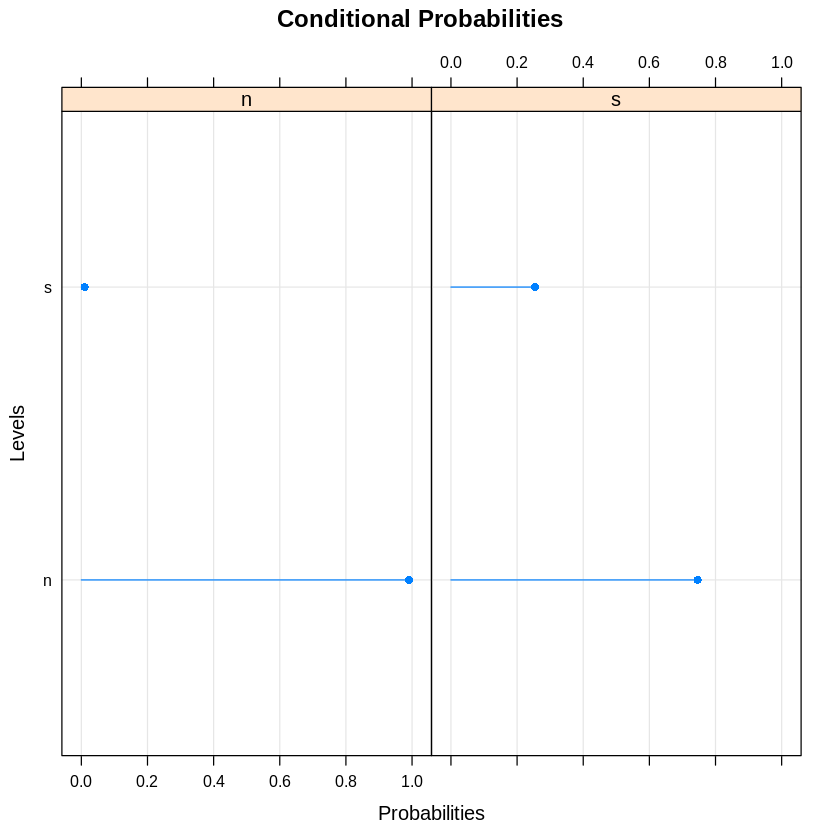

In [45]:
# http://www.bnlearn.com/documentation/man/bn.fit.plots.html
bn.fit.dotplot(bn_meteoro$granizo)

In [44]:
bn_meteoro$niebla


  Parameters of node niebla (multinomial distribution)

Conditional probability table:
 
, , viento = n

      rocio
niebla           n           s
     n 0.946399802 0.855234203
     s 0.053600198 0.144765797

, , viento = s

      rocio
niebla           n           s
     n 0.995195025 0.934108527
     s 0.004804975 0.065891473


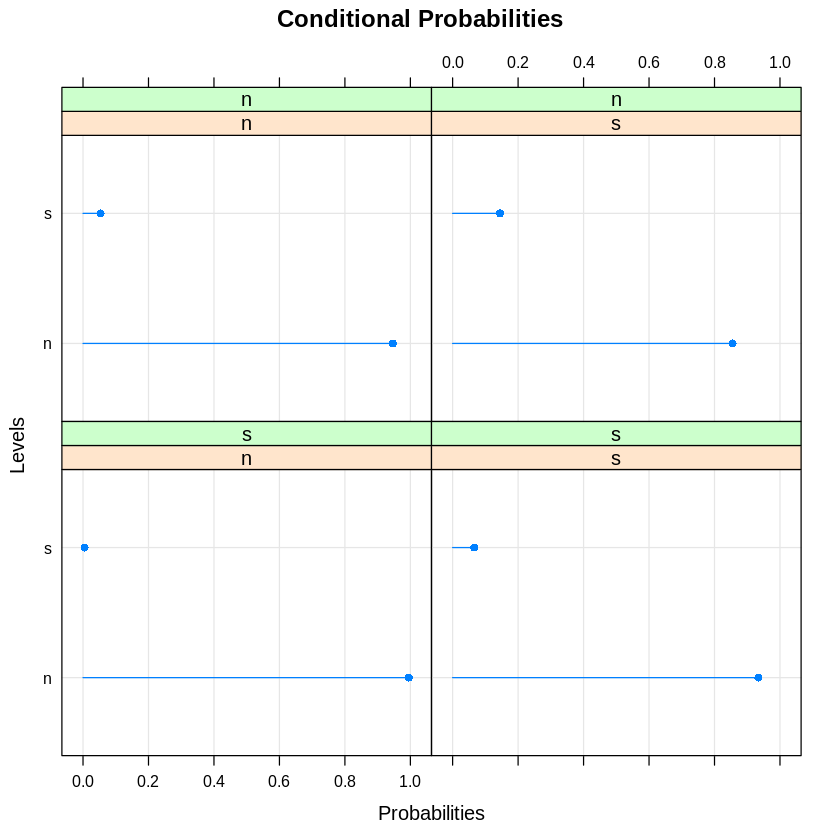

In [46]:
# http://www.bnlearn.com/documentation/man/bn.fit.plots.html
bn.fit.dotplot(bn_meteoro$niebla)

## Ejercicio 3 (2.5 Puntos)

Una vez construída la red hemos establecido la base de conocimiento del sistema inteligente. A continuación se puede calcular la probabilidad de cualquier variable o conjunto de variables condicionadas a cualquier evidencia que se tenga disponible para un problema dado, es decir, realizar la inferencia. 

Observa la estructura del DAG y repasa la teoría y el concepto de _d-separación_. Responde razonadamente si las siguientes afirmaciones son verdaderas o falsas, utilizando únicamente la estructura del DAG y el concepto de d-separación:

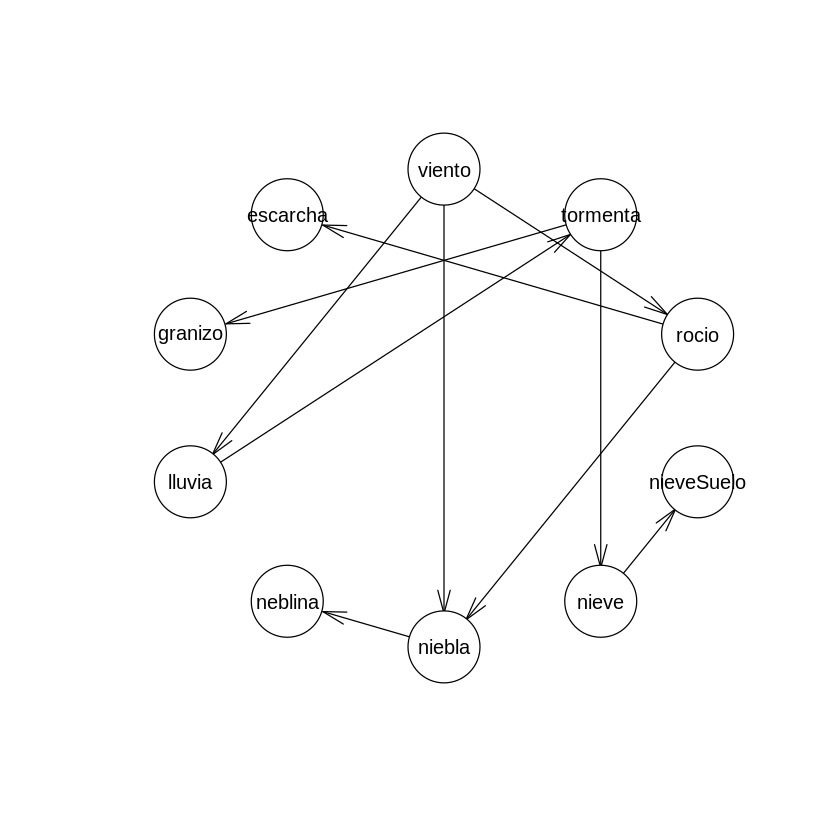

In [49]:
plot(dag)

**::GMG::** De la teoría:

> La separación gráfica de dos variables ($\perp_{G}$ - `dsep()`) implica independencia probabilística ($\perp_{P}$) en la red bayesiana. Si todas las trayectorias (`path()`) entre $X$ e $Y$ se encuentran bloqueadas, se dice que $X$ e $Y$ son (condicionalmente) independientes dada una tercera variable $Z$, lo que representamos como $X \perp_{G} Y | Z$. Lo contrario no es necesariamente cierto: no todas las relaciones de independencia condicional se encuentran reflejadas en el grafo.

+ La nieve y el granizo son fenómenos independientes a priori

**::GMG::** Traducción: ¿$I(nieve, granizo \mid \emptyset)$? o ¿$nieve \perp_{G} granizo$?

In [7]:
dsep(bn = dag, x = 'nieve', y = 'granizo')

[1] FALSE

**::GMG::** $nieve \not \perp_{G} granizo \implies nieve \not \perp_{P} granizo$

**Respuesta**: Las variables *no son independientes*. Están unidas por `tormenta` en una estructura de *divergente* con `tormenta`. 

+ La nieve y el granizo son fenómenos independientes dado que haya habido tormenta

**::GMG::** Traducción: ¿$I(nieve, granizo \mid tormenta)$? o ¿$nieve \perp_{G} granizo \mid tormenta$?

In [9]:
dsep(bn = dag, x = 'nieve', y = 'granizo', z = 'tormenta')

[1] TRUE

**::GMG::** $nieve \perp_{G} granizo \mid tormenta \implies nieve \perp_{P} granizo \mid tormenta$ con nieve &larr; tormenta &rarr; granizo

Respuesta: `nieve` y `granizo` están en una estructura *divergente* con centro en `tormenta` por lo que hay un camino que se ve *bloqueado* cuando se *activa* la evidencia de `tormenta` dando como resultado la *independencia condicional* de ambas variables.

In [10]:
path(x = dag, from = 'nieve', to = 'granizo', 
     underlying.graph = TRUE, debug = TRUE)

* currently at 'nieve'.
  > current path is:
'nieve' 
  > jumping to 'nieveSuelo'.
* currently at 'nieveSuelo'.
  > current path is:
'nieve' 'nieveSuelo' 
  @ node 'nieve' already visited, skipping.
  > node 'nieveSuelo' has no more children, going back to 'nieve'.
  > jumping to 'tormenta'.
* currently at 'tormenta'.
  > current path is:
'nieve' 'tormenta' 
  > jumping to 'granizo'.


[1] TRUE

+ La nieve en el suelo y la neblina son fenómenos independientes

**::GMG::** Traducción: ¿$I(nieveSuelo, neblina \mid \emptyset)$? o ¿$nieveSuelo \perp_{G} neblina$?

In [12]:
dsep(bn = dag, x = 'nieveSuelo', y = 'neblina')

[1] FALSE

In [14]:
path(x = dag, from = 'nieveSuelo', to = 'neblina', 
     underlying.graph = TRUE, debug = TRUE)

* currently at 'nieveSuelo'.
  > current path is:
'nieveSuelo' 
  > jumping to 'nieve'.
* currently at 'nieve'.
  > current path is:
'nieveSuelo' 'nieve' 
  @ node 'nieveSuelo' already visited, skipping.
  > jumping to 'tormenta'.
* currently at 'tormenta'.
  > current path is:
'nieveSuelo' 'nieve' 'tormenta' 
  > jumping to 'granizo'.
* currently at 'granizo'.
  > current path is:
'nieveSuelo' 'nieve' 'tormenta' 'granizo' 
  @ node 'tormenta' already visited, skipping.
  > node 'granizo' has no more children, going back to 'tormenta'.
  > jumping to 'lluvia'.
* currently at 'lluvia'.
  > current path is:
'nieveSuelo' 'nieve' 'tormenta' 'lluvia' 
  @ node 'tormenta' already visited, skipping.
  > jumping to 'viento'.
* currently at 'viento'.
  > current path is:
'nieveSuelo' 'nieve' 'tormenta' 'lluvia' 'viento' 
  @ node 'lluvia' already visited, skipping.
  > jumping to 'niebla'.
* currently at 'niebla'.
  > current path is:
'nieveSuelo' 'nieve' 'tormenta' 'lluvia' 'viento' 'niebla' 


[1] TRUE

**::GMG::** $nieveSuelo \not \perp_{G} neblina \implies nieveSuelo \not \perp_{P} neblina$

**Respuesta**: Las variables *no son independientes*. Hay un camino por ascendientes que no se ve bloqueado por la activación de ninguna evidencia.

+ La nieve en el suelo y la neblina son fenómenos independientes dado que haya habido tormenta

**::GMG::** Traducción: ¿$I(nieveSuelo, neblina \mid tormenta)$? o ¿$nieveSuelo \perp_{G} neblina \mid tormenta$?

In [15]:
dsep(bn = dag, x = 'nieveSuelo', y = 'neblina', z = 'tormenta')

[1] TRUE

**::GMG::** $nieveSuelo \perp_{G} neblina \mid tormenta \implies nieveSuelo \perp_{P} neblina \mid tormenta$

**Respuesta**: `nieveSuelo` y `neblina` están conectadas por un camino que cuando se *activa* la evidencia de `tormenta` se bloquea dando como resultado la *independencia condicionada* de ambas variables.

#### Inferencia exacta

NOTA: En este apartado se deberá aplicar la inferencia exacta. 

In [28]:
suppressMessages(library(gRain))

In [29]:
junction_meteoro <- compile(as.grain(bn_meteoro))

Conocido que en un día dado se han producido tormentas, calcula cómo afecta este hecho a la probabilidad de que se produzcan los siguientes fenómenos meteorológicos:

* Que llueva, $P(lluvia = s | tormenta = s)$

In [30]:
print(querygrain(junction_meteoro, nodes = 'lluvia')$lluvia)

lluvia
        n         s 
0.4443261 0.5556739 


In [31]:
j_tormenta <- setFinding(object = junction_meteoro,
                         nodes = 'tormenta',
                         states = 's')

In [32]:
print(querygrain(j_tormenta, nodes = 'lluvia')$lluvia)

lluvia
         n          s 
0.04014599 0.95985401 


**::GMG::** Parece lógico que en una tormenta se dispare la probabilidad de lluvia. Sin embargo hay que notar una ligera bajada de la probabilidad de que no llueva. Creo que eso es debido a que existen también las [tormentas secas](https://en.wikipedia.org/wiki/Dry_thunderstorm) en las que la precipitación *se evapora* antes de alcanzar el suelo.

* Que haya rachas de viento superiores a 50 Km/h, $P(viento = s | tormenta = s)$

In [33]:
print(querygrain(junction_meteoro, nodes = 'viento')$viento)

viento
        n         s 
0.8556434 0.1443566 


In [36]:
print(querygrain(j_tormenta, nodes = 'viento')$viento)

viento
        n         s 
0.7831392 0.2168608 


**::GMG::** Parece que aumenta *ligeramente* la probabilidad de rechas superiores a 50 Km/h cuando hay tormenta en el Aeropuerto de Santander. Esto entiendo que puede ser importante a la hora de usar un protocolo para negociar los despegues y aterrizajes.

* Que llueva y que además las rachas de viento superen los 50 Km/h, $P(lluvia = s, viento = n | tormenta = s)$

In [38]:
lluviaxviento <- querygrain(junction_meteoro, 
                            nodes = c('lluvia', 'viento'), 
                            type = "joint")
print(lluviaxviento)

      lluvia
viento          n         s
     n 0.42447521 0.4311682
     s 0.01985093 0.1245056


In [39]:
lluviaxviento_tormenta <- querygrain(j_tormenta, 
                                nodes = c('lluvia', 'viento'), 
                                type = "joint")
print(lluviaxviento_tormenta)

      lluvia
viento           n         s
     n 0.038352404 0.7447868
     s 0.001793581 0.2150672


**::GMG::** Se ve que en caso de tormenta, la *lluvia con viento de menos de 50 Km/h* es mucho más probable.

A partir de la información revelada por la red bayesiana, sabiendo que un día se producen tormentas:       

* ¿Hay mayor probabilidad de que llueva cuando se producen tormentas que cualquier otro día?

**::GMG::** La probabilidad marginal de lluvia es `0.5556739` mientras que si se producen tormentas la BN nos recalcula la probabilidad de lluvia en `0.95985401`. Claramente aumenta de forma significativa la probabilidad de lluvia.

* ¿Aumenta o disminuye la probabilidad de tener rachas de viento mayores de 50 Km/h cuando se produce tormenta? ¿Cuánto?

**::GMG::** La probabilidad de rachas de viento mayores de 50 Km/h pasan de `0.1443566` sin evidencia de tormenta a `0.2168608`. Es un aumento pero no es muy grande. 

#### Inferencia aproximada

Dado el ejercicio anterior, repetir ahora el ejercicio mediante inferencia aproximada, calculando para cada una de las estimaciones 100 realizaciones. Para cada una de las respuestas anteriores, representa un diagrama de cajas que represente la dispersión en la estimación de la probabilidad, marcando además el valor obtenido de manera exacta en el apartado anterior.

## Ejercicio 4 (2.5 Puntos)

Como hemos visto, es posible realizar un aprendizaje automático de la estructura del DAG a partir de los datos, usando algoritmos específicos para ello. Durante las clases hemos visto el ejemplo del algoritmo _hill-climbing_, aunque como vimos, hay otras posibilidades. Tambien hemos visto que podemos combinar nuestra experiencia y el aprendizaje automático definiendo previamente relaciones entre variables que queremos introducir o descartar en el DAG resultante. Además, se ha explicado que existen _scores_ que sirven como criterio para evaluar la fuerza de la dependendencia entre nodos de la red y comparar la bondad de ajuste del modelo.

* Evalúa la significación de los arcos dibujados por el experto en el actual DAG utilizando el estadístico $\chi^2$. ¿Hay algún arco no significativo? ¿Cuáles son los tres pares de nodos que presentan un arco de unión más fuerte?

Además del algoritmo _hill-climbing_, existe otro algoritmo popular de tipo "voraz" denominado _Tabu search_. En `bnlearn` se encuentra implementado a traves de la función `tabu`, y los argumentos de entrada son similares a los vistos para _hill-climbing_. 

* Compara el score global (BIC) obtenido por el DAG inicial, con los obtenidos por los DAG aprendidos de forma automática con los algoritmos _tabu_ y _hill-climbing_. ¿Cuál obtiene mejor score?

   * Ahora, para comparar el DAG original con los dos nuevos DAG tabu y hill-climbing, dibuja los tres utilizando la función `graphviz.plot`. A la luz de los grafos obtenidos en cada caso, ¿cuál te parece que recoge mejor las relaciones causa-efecto entre variables?. Hay que tener en cuenta que los arcos de un grafo __no expresan causalidad__, sino simplemente dependencia entre variables en términos de probabilidad. 

* Ahora vuelve a aprender de forma automática el DAG usando tabu y hill-climbing, pero imponiendo las siguientes restricciones:
     1. Los arcos `viento --> lluvia`, `tormenta --> granizo` y `nieve --> nieveSuelo` deben quedar reflejados en el DAG.
     2. Ningún arco debe unir directamente la neblina con el granizo ni la niebla con la tormenta.

   * Vuelve a dibujar los DAG resultantes, y a partir del BIC obtenido por cada modelo, determina cuál es el mejor de todos poniéndolos en una tabla.

   * Computa la fuerza de la relación entre nodos de los dos últimos modelos que combinan nuestra experiencia con el aprendizaje automático. 

   * Comenta brevemente los resultados obtenidos tras combinar nuestro conocimiento con el aprendizaje automático.   